In [1]:
!git clone -b patch-1 https://github.com/htuannn/STR-Fewer-Labels.git

Cloning into 'STR-Fewer-Labels'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 158 (delta 47), reused 20 (delta 20), pack-reused 105
Receiving objects: 100% (158/158), 1.65 MiB | 10.88 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [2]:
%cd STR-Fewer-Labels

/content/STR-Fewer-Labels


In [3]:
!pip3 install lmdb pillow torchvision nltk natsort fire tensorboard tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.5/298.5 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116952 sha256=ee00bb9c5daa02fad140bc16a1ed5d787e785ca9227f76d4d85421055683ac67
  Stored in directory: /root/.cache/pip/wheels/f7/f1/89/b9ea2bf8f80ec027a88fef1d354b3816b4d3d29530988972f6
Successfully built fire


In [4]:
!pip install lmdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!wget https://www.dropbox.com/sh/23adceu2i85c4x1/AADWC24lD7Rw3QsstSHkY4oZa/CRNN-Baseline-synth.pth?dl=0

--2023-04-22 16:34:03--  https://www.dropbox.com/sh/23adceu2i85c4x1/AADWC24lD7Rw3QsstSHkY4oZa/CRNN-Baseline-synth.pth?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /sh/raw/23adceu2i85c4x1/AADWC24lD7Rw3QsstSHkY4oZa/CRNN-Baseline-synth.pth [following]
--2023-04-22 16:34:03--  https://www.dropbox.com/sh/raw/23adceu2i85c4x1/AADWC24lD7Rw3QsstSHkY4oZa/CRNN-Baseline-synth.pth
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdc23928c2b2d383c6492be69f7.dl.dropboxusercontent.com/cd/0/inline/B6pnTPNAD2pnwBWZQHlLCyI9wPt1rH0ojnxo6J4dfWcTbQ4w9EJD_73DXPT3aqMsUgp2CHt4KblW_tMzrf5Iz93MJ4TJH1rH_j0nUOmKQmIiwxYsNrlgXOepStfrUgbDsYT-HOyMSHJJAYDUilhQpOHSdaUGiBySAuRinecb5Gd8kA/file# [following]
--2023-04-22 16:34:04--  https://ucdc23928c2b2d383c6492be69f7

In [6]:
!mv 'CRNN-Baseline-synth.pth?dl=0' CRNN-Baseline-synth.pth

In [7]:
import sys
import string
import argparse

import torch
import torch.backends.cudnn as cudnn
import torch.utils.data
import torch.nn.functional as F

from utils import CTCLabelConverter, AttnLabelConverter
from dataset import RawDataset, AlignCollate
from model import Model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
parser = argparse.ArgumentParser()
parser.add_argument(
    "--image_folder",
    default="demo_image/",
    help="path to image_folder which contains text images",
)
parser.add_argument(
    "--workers", type=int, help="number of data loading workers", default=4
)
parser.add_argument("--batch_size", type=int, default=192, help="input batch size")
parser.add_argument(
    "--saved_model", required=True, help="path to saved_model to evaluation"
)
""" Data processing """
parser.add_argument(
    "--batch_max_length", type=int, default=25, help="maximum-label-length"
)
parser.add_argument(
    "--imgH", type=int, default=32, help="the height of the input image"
)
parser.add_argument(
    "--imgW", type=int, default=100, help="the width of the input image"
)
parser.add_argument(
    "--Prediction",
    type=str,
    default="CTC"
)
parser.add_argument(
    "--character",
    type=str,
    default="0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~",
    help="character label",
)
parser.add_argument("--Aug", type=str, default="None", help="placeholder")
parser.add_argument("--semi", type=str, default="None", help="placeholder")
""" Model Architecture """
parser.add_argument("--model_name", type=str, required=True, help="CRNN|TRBA")
parser.add_argument(
    "--num_fiducial",
    type=int,
    default=20,
    help="number of fiducial points of TPS-STN",
)
parser.add_argument(
    "--input_channel",
    type=int,
    default=3,
    help="the number of input channel of Feature extractor",
)
parser.add_argument(
    "--output_channel",
    type=int,
    default=512,
    help="the number of output channel of Feature extractor",
)
parser.add_argument(
    "--hidden_size", type=int, default=256, help="the size of the LSTM hidden state"
)


_StoreAction(option_strings=['--hidden_size'], dest='hidden_size', nargs=None, const=None, default=256, type=<class 'int'>, choices=None, required=False, help='the size of the LSTM hidden state', metavar=None)

In [9]:
opt=parser.parse_args('--model_name CRNN --image_folder demo_image/ \
--saved_model CRNN-Baseline-synth.pth'.split())
if opt.model_name == "CRNN":
    opt.Transformation = "None"
    opt.FeatureExtraction = "VGG"
    opt.SequenceModeling = "BiLSTM"
    opt.Prediction = "CTC"

elif opt.model_name == "TRBA":
    opt.Transformation = "TPS"
    opt.FeatureExtraction = "ResNet"
    opt.SequenceModeling = "BiLSTM"
    opt.Prediction = "Attn"

cudnn.benchmark = True  # It fasten training.
cudnn.deterministic = True

opt.num_gpu = torch.cuda.device_count()

In [10]:
if "CTC" in opt.Prediction:
    converter = CTCLabelConverter(opt.character)
else:
    converter = AttnLabelConverter(opt.character)
    opt.sos_token_index = converter.dict["[SOS]"]
    opt.eos_token_index = converter.dict["[EOS]"]
opt.num_class = len(converter.character)

model = Model(opt)
print(
    "model input parameters",
    opt.imgH,
    opt.imgW,
    opt.num_fiducial,
    opt.input_channel,
    opt.output_channel,
    opt.hidden_size,
    opt.num_class,
    opt.batch_max_length,
    opt.Transformation,
    opt.FeatureExtraction,
    opt.SequenceModeling,
    opt.Prediction,
)
model = torch.nn.DataParallel(model).to(device)

# load model
print("loading pretrained model from %s" % opt.saved_model)
model.load_state_dict(torch.load(opt.saved_model, map_location=device))


# of tokens and characters: 98
No Transformation module specified
model input parameters 32 100 20 3 512 256 98 25 None VGG BiLSTM CTC
loading pretrained model from CRNN-Baseline-synth.pth


<All keys matched successfully>

# Download data

In [11]:
!wget -O data_CVPR2021.zip https://www.dropbox.com/sh/1s6r4slurc5ei2n/AABJZzmWTCNt6EWVXbQ-QdDUa/data_CVPR2021.zip?dl=0

--2023-04-22 16:34:18--  https://www.dropbox.com/sh/1s6r4slurc5ei2n/AABJZzmWTCNt6EWVXbQ-QdDUa/data_CVPR2021.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /sh/raw/1s6r4slurc5ei2n/AABJZzmWTCNt6EWVXbQ-QdDUa/data_CVPR2021.zip [following]
--2023-04-22 16:34:18--  https://www.dropbox.com/sh/raw/1s6r4slurc5ei2n/AABJZzmWTCNt6EWVXbQ-QdDUa/data_CVPR2021.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc600d1b2059a0459aea99be308e.dl.dropboxusercontent.com/cd/0/inline/B6rE42V50vYFP9JbMdMRnwsCWoYdcUs685KDbANxAIHdqCh6d0oT_v56Y2Zy879oFb5YhAyDStZ_J137vnEuR4l9LbzodBkecavr7UJqAccsSZ7bkrUMsEAIKkI3w4zSYUlJcpyo1sMNU62c-l2TDY5HYZy9GkQUhIGgvkPy5sieqw/file# [following]
--2023-04-22 16:34:19--  https://uc600d1b2059a0459aea99be308e.dl.dropboxusercon

In [12]:
!unzip /content/STR-Fewer-Labels/data_CVPR2021.zip

Archive:  /content/STR-Fewer-Labels/data_CVPR2021.zip
   creating: data_CVPR2021/
   creating: data_CVPR2021/evaluation/
   creating: data_CVPR2021/evaluation/addition/
   creating: data_CVPR2021/evaluation/addition/5.COCO/
  inflating: data_CVPR2021/evaluation/addition/5.COCO/lock.mdb  
  inflating: data_CVPR2021/evaluation/addition/5.COCO/data.mdb  
   creating: data_CVPR2021/evaluation/addition/8.ArT/
  inflating: data_CVPR2021/evaluation/addition/8.ArT/lock.mdb  
  inflating: data_CVPR2021/evaluation/addition/8.ArT/data.mdb  
   creating: data_CVPR2021/evaluation/addition/9.LSVT/
  inflating: data_CVPR2021/evaluation/addition/9.LSVT/data.mdb  
  inflating: data_CVPR2021/evaluation/addition/9.LSVT/lock.mdb  
   creating: data_CVPR2021/evaluation/addition/11.ReCTS/
  inflating: data_CVPR2021/evaluation/addition/11.ReCTS/lock.mdb  
  inflating: data_CVPR2021/evaluation/addition/11.ReCTS/data.mdb  
   creating: data_CVPR2021/evaluation/addition/7.Uber/
  inflating: data_CVPR2021/evalua

In [13]:
import os
import sys
import time
import random
import string
import argparse

import torch
import torch.backends.cudnn as cudnn
import torch.nn.init as init
import torch.utils.data
import torch.nn.functional as F
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

from utils import CTCLabelConverter, AttnLabelConverter, Averager, adjust_learning_rate
from dataset import hierarchical_dataset, AlignCollate, Batch_Balanced_Dataset
from model import Model
#from test import validation, benchmark_all_eval
from modules.semi_supervised import PseudoLabelLoss, MeanTeacherLoss

In [14]:
log = open(f"./log_demo_result.txt", "w")

In [15]:
select_data_unlabel = ["U3.STVQA"]
batch_ratio_unlabel = [round(1 / len(select_data_unlabel), 3)] * len(
    select_data_unlabel
)
dataset_root_unlabel = "data_CVPR2021/training/unlabel/"
train_loader_unlabel_semi = Batch_Balanced_Dataset(
    opt,
    dataset_root_unlabel,
    select_data_unlabel,
    batch_ratio_unlabel,
    log,
    learn_type="semi",
)

--------------------------------------------------------------------------------
dataset_root: data_CVPR2021/training/unlabel/
select_data: ['U3.STVQA']
batch_ratio: [1.0]
Use Text_augment [Resize(size=(32, 100), interpolation=bicubic, max_size=None, antialias=warn), ToTensor()]
--------------------------------------------------------------------------------
dataset_root:    data_CVPR2021/training/unlabel/	 dataset: U3.STVQA
sub-directory:	/U3.STVQA	 num samples: 68544
num total samples of U3.STVQA: 68544
num samples of U3.STVQA per batch: 192 x 1.0 (batch_ratio) = 192


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


--------------------------------------------------------------------------------
Total_batch_size: 192 = 192
--------------------------------------------------------------------------------


In [16]:
image_unlabel, image_unlabel1= train_loader_unlabel_semi.get_batch_two_images()
image_unlabel = image_unlabel.to('cuda')

In [17]:
model.eval()
with torch.no_grad():
    log = open(f"./log_demo_result.txt", "w")
    image = image_unlabel.to(device)
    print(image.shape)
    if "CTC" in opt.Prediction:
        PseudoLabel_pred =  model(image)

torch.Size([192, 3, 32, 100])


In [18]:
from IPython.core.display import display, HTML
from PIL import Image
import base64
import io
import pandas as pd

In [19]:
batch_size=image_unlabel.size(0)
preds_size = torch.IntTensor([PseudoLabel_pred.size(1)] * batch_size).to(device)
_, preds_index = PseudoLabel_pred.max(2)
preds_str = converter.decode(preds_index, preds_size)

dashed_line = "-" * 80

preds_prob = F.softmax(PseudoLabel_pred, dim=2)
preds_max_prob, _ = preds_prob.max(dim=2)
data = pd.DataFrame()
for ind, (img, pred, pred_max_prob) in enumerate(zip(
    image_unlabel,preds_str, preds_max_prob
)):
    # calculate confidence score (= multiply of pred_max_prob)
    confidence_score = pred_max_prob.cumprod(dim=0)[-1]
    img=img.cpu().numpy().transpose((1,2,0))
    PIL_image = Image.fromarray(np.uint8((img+1)*127.5)).convert("RGB")
    img_buffer = io.BytesIO()
    PIL_image.save(img_buffer, format="PNG")
    imgStr = base64.b64encode(img_buffer.getvalue()).decode("utf-8") 

    data.loc[ind, 'img'] = '<img src="data:image/png;base64,{0:s}">'.format(imgStr)
    data.loc[ind, 'label'] = pred
    data.loc[ind, 'conf'] = round(confidence_score.cpu().item(),4)


,img,label,conf
0,,RAMP,0.9165
1,,Apare,0.0423
2,,WORKSHOP,0.4856
3,,(hop,0.0380
4,,until,0.7576
5,,maving,0.0012
6,,RVICE,0.3406
7,,eskep,0.7914
8,,use,0.5105
9,,$4.25,0.5116

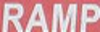
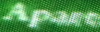
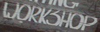
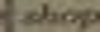
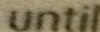
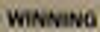
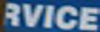
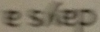
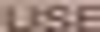
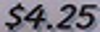
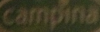
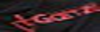
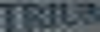
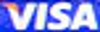
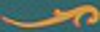
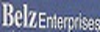
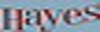
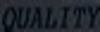
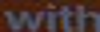
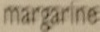
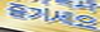
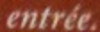
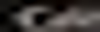
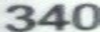
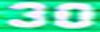
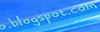
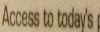
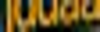
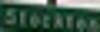
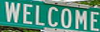
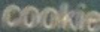
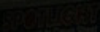
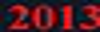
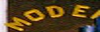
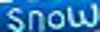
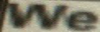
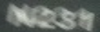
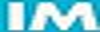
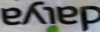
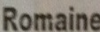
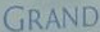
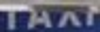
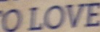
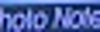
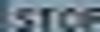
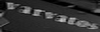
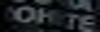
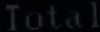
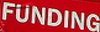
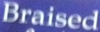
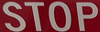
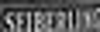
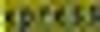
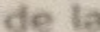
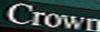
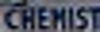
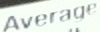
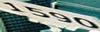
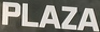
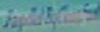
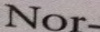
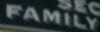
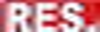
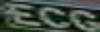
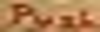
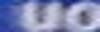
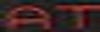
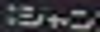
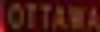
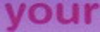
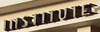
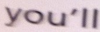
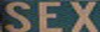
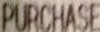
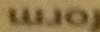
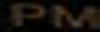
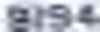
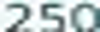
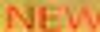
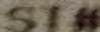
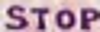
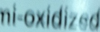
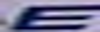
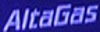
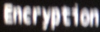
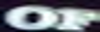
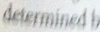
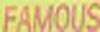
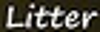
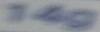
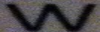
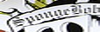
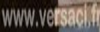
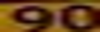
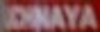
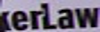
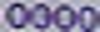
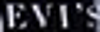
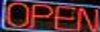
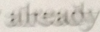
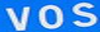
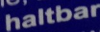
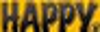
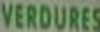
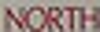
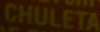
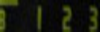
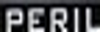
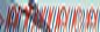
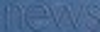
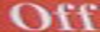
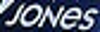
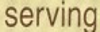
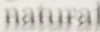
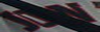
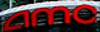
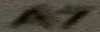
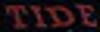
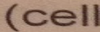
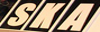
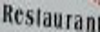
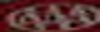
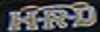
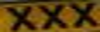
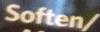
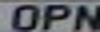
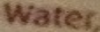
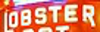
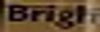
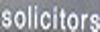
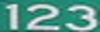
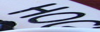
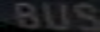
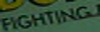
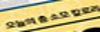
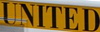
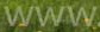
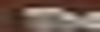
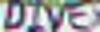
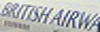
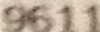
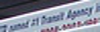
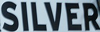
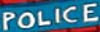
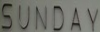
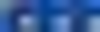
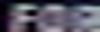
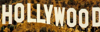
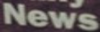
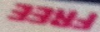
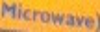
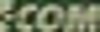
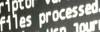
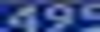
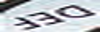
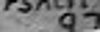
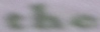
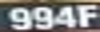
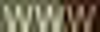
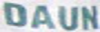
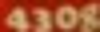
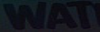
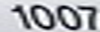
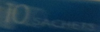
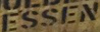
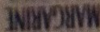
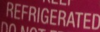
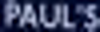
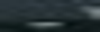
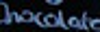
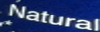
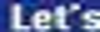
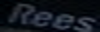
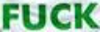
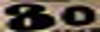
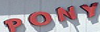
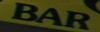
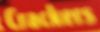
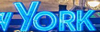
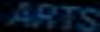
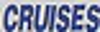
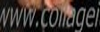
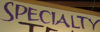
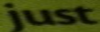
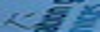
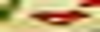
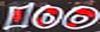
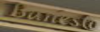
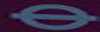
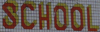
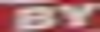
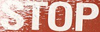

In [20]:
html_all = data.to_html(escape=False)
display(HTML(html_all))

In [21]:
class data(object):
  def __init__(self, opt, dataset_, self, opt, dataset_root, select_data, log):
    self.opt= opt

    _dataset, _dataset_log = hierarchical_dataset(
              root=dataset_root,
              opt=self.opt,
              select_data= select_data,
              data_type=data_type,
    )
    total_number_dataset = len(_dataset)

    selected_d_log = f"num total samples of {selected_d}: {len(_dataset)}\n"
    print(selected_d_log)

    if learn_type == "semi":
        _AlignCollate = AlignCollate_SemiSL(self.opt)
        data_type = "unlabel"
        
    _data_loader = torch.utils.data.DataLoader(
      _dataset,
      batch_size=_batch_size,
      shuffle=True,
      num_workers=int(self.opt.workers),
      collate_fn=_AlignCollate,
      pin_memory=False,
      drop_last=False,
    )

SyntaxError: ignored

In [73]:
import os
import sys
import re
import six
import time
import math
import random

from natsort import natsorted
import PIL
import lmdb
import numpy as np
import torch
from torch.utils.data import Dataset, ConcatDataset, Subset
from torch._utils import _accumulate
import torchvision.transforms as transforms


class Batch_Balanced_Dataset(object):
    def __init__(
        self, opt, dataset_root, select_data, batch_ratio, log, learn_type=None
    ):
        """
        Modulate the data ratio in the batch.
        For example, when select_data is "MJ-ST" and batch_ratio is "0.5-0.5",
        the 50% of the batch is filled with MJ and the other 50% of the batch is filled with ST.
        """
        self.opt = opt
        dashed_line = "-" * 80
        print(dashed_line)
        log.write(dashed_line + "\n")
        print(
            f"dataset_root: {dataset_root}\nselect_data: {select_data}\nbatch_ratio: {batch_ratio}"
        )
        log.write(
            f"dataset_root: {dataset_root}\nselect_data: {select_data}\nbatch_ratio: {batch_ratio}\n"
        )
        assert len(select_data) == len(batch_ratio)

        if learn_type == "semi":
            _AlignCollate = AlignCollate_SemiSL(self.opt)
            data_type = "unlabel"
        elif learn_type == "self":
            _AlignCollate = AlignCollate_SelfSL(self.opt)
            data_type = "unlabel"
        else:
            _AlignCollate = AlignCollate(self.opt)
            data_type = "label"

        self.data_loader_list = []
        self.dataloader_iter_list = []
        batch_size_list = []
        Total_batch_size = 0
        for selected_d, batch_ratio_d in zip(select_data, batch_ratio):
            _batch_size = max(round(self.opt.batch_size * float(batch_ratio_d)), 1)
            print(dashed_line)
            log.write(dashed_line + "\n")
            _dataset, _dataset_log = hierarchical_dataset(
                root=dataset_root,
                opt=self.opt,
                select_data=[selected_d],
                data_type=data_type,
            )
            total_number_dataset = len(_dataset)
            log.write(_dataset_log)

            if data_type == "label":
                """
                The total number of data can be modified with opt.total_data_usage_ratio.
                ex) opt.total_data_usage_ratio = 1 indicates 100% usage, and 0.2 indicates 20% usage.
                """
                number_dataset = int(
                    total_number_dataset * float(self.opt.total_data_usage_ratio)
                )
                dataset_split = [number_dataset, total_number_dataset - number_dataset]
                indices = range(total_number_dataset)
                _dataset, _ = [
                    Subset(_dataset, indices[offset - length : offset])
                    for offset, length in zip(_accumulate(dataset_split), dataset_split)
                ]
                selected_d_log = f"num total samples of {selected_d}: {total_number_dataset} x {self.opt.total_data_usage_ratio} (total_data_usage_ratio) = {len(_dataset)}\n"
            else:
                # as a default, we use always 100% of unlabeled dataset.
                selected_d_log = f"num total samples of {selected_d}: {len(_dataset)}\n"
            selected_d_log += f"num samples of {selected_d} per batch: {self.opt.batch_size} x {float(batch_ratio_d)} (batch_ratio) = {_batch_size}"
            print(selected_d_log)
            log.write(selected_d_log + "\n")
            batch_size_list.append(str(_batch_size))
            Total_batch_size += _batch_size

            # for faster training, we multiply small datasets itself.
            if len(_dataset) < 50000:
                multiple_times = int(50000 / len(_dataset))
                dataset_self_multiple = [_dataset] * multiple_times
                _dataset = ConcatDataset(dataset_self_multiple)

            _data_loader = torch.utils.data.DataLoader(
                _dataset,
                batch_size=_batch_size,
                shuffle=True,
                num_workers=int(self.opt.workers),
                collate_fn=_AlignCollate,
                pin_memory=False,
                drop_last=False,
            )

            self.data_loader_list.append(_data_loader)
            self.dataloader_iter_list.append(iter(_data_loader))

        Total_batch_size_log = f"{dashed_line}\n"
        batch_size_sum = "+".join(batch_size_list)
        Total_batch_size_log += (
            f"Total_batch_size: {batch_size_sum} = {Total_batch_size}\n"
        )
        Total_batch_size_log += f"{dashed_line}"
        if data_type == "label":
            self.opt.Total_batch_size = Total_batch_size
        elif data_type == "unlabel":
            self.opt.Total_unlabel_batch_size = Total_batch_size

        print(Total_batch_size_log)
        log.write(Total_batch_size_log + "\n")

    def get_batch(self):
        balanced_batch_images = []
        balanced_batch_labels = []

        for i, data_loader_iter in enumerate(self.dataloader_iter_list):
            try:
                image, label = next(data_loader_iter)
                balanced_batch_images.append(image)
                balanced_batch_labels += label
            except StopIteration:
                self.dataloader_iter_list[i] = iter(self.data_loader_list[i])
                image, label = next(self.dataloader_iter_list[i])
                balanced_batch_images.append(image)
                balanced_batch_labels += label
            except ValueError:
                pass

        balanced_batch_images = torch.cat(balanced_batch_images, 0)

        return balanced_batch_images, balanced_batch_labels

    def get_batch_ema(self):
        balanced_batch_images = []
        balanced_batch_images_ema = []
        balanced_batch_texts = []

        for i, data_loader_iter in enumerate(self.dataloader_iter_list):
            try:
                image, image_ema, text = next(data_loader_iter)
                balanced_batch_images.append(image)
                balanced_batch_images_ema.append(image_ema)
                balanced_batch_texts += text
            except StopIteration:
                self.dataloader_iter_list[i] = iter(self.data_loader_list[i])
                image, image_ema, text = next(self.dataloader_iter_list[i])
                balanced_batch_images.append(image)
                balanced_batch_images_ema.append(image_ema)
                balanced_batch_texts += text
            except ValueError:
                pass

        balanced_batch_images = torch.cat(balanced_batch_images, 0)
        balanced_batch_images_ema = torch.cat(balanced_batch_images_ema, 0)

        return balanced_batch_images, balanced_batch_images_ema, balanced_batch_texts

    def get_batch_two_images(self):
        """two images
        ex) For MoCo, q and k
        ex) For Mean Teacher, image with aug1 and image with aug2
        """
        balanced_batch_img1 = []
        balanced_batch_img2 = []

        for i, data_loader_iter in enumerate(self.dataloader_iter_list):
            try:
                image_aug1, image_aug2 = next(data_loader_iter)
                balanced_batch_img1.append(image_aug1)
                balanced_batch_img2.append(image_aug2)
            except StopIteration:
                self.dataloader_iter_list[i] = iter(self.data_loader_list[i])
                image_aug1, image_aug2 = next(self.dataloader_iter_list[i])
                balanced_batch_img1.append(image_aug1)
                balanced_batch_img2.append(image_aug2)
            except ValueError:
                pass

        balanced_batch_img1 = torch.cat(balanced_batch_img1, 0)
        balanced_batch_img2 = torch.cat(balanced_batch_img2, 0)

        return balanced_batch_img1, balanced_batch_img2


def hierarchical_dataset(root, opt, select_data="/", data_type="label", mode="train"):
    """select_data='/' contains all sub-directory of root directory"""
    dataset_list = []
    dataset_log = f"dataset_root:    {root}\t dataset: {select_data}"
    print(dataset_log)
    dataset_log += "\n"
    for dirpath, dirnames, filenames in os.walk(root + "/"):
        if not dirnames:
            select_flag = False
            for selected_d in select_data:
                if selected_d in dirpath:
                    select_flag = True
                    break

            if select_flag:
                if data_type == "label":
                    dataset = LmdbDataset(dirpath, opt, mode=mode)
                else:
                    dataset = LmdbDataset_unlabel(dirpath, opt)
                sub_dataset_log = f"sub-directory:\t/{os.path.relpath(dirpath, root)}\t num samples: {len(dataset)}"
                print(sub_dataset_log)
                dataset_log += f"{sub_dataset_log}\n"
                dataset_list.append(dataset)
    concatenated_dataset = ConcatDataset(dataset_list)
    concatenated_dataset.index_list= np.array([index  for index in range(len(concatenated_dataset))])
    return concatenated_dataset, dataset_log


class LmdbDataset(Dataset):
    def __init__(self, root, opt, mode="train"):

        self.root = root
        self.opt = opt
        self.mode = mode
        self.env = lmdb.open(
            root,
            max_readers=32,
            readonly=True,
            lock=False,
            readahead=False,
            meminit=False,
        )
        if not self.env:
            print("cannot open lmdb from %s" % (root))
            sys.exit(0)

        with self.env.begin(write=False) as txn:
            self.nSamples = int(txn.get("num-samples".encode()))
            self.filtered_index_list = []
            for index in range(self.nSamples):
                index += 1  # lmdb starts with 1
                label_key = "label-%09d".encode() % index
                label = txn.get(label_key).decode("utf-8")

                # length filtering
                length_of_label = len(label)
                if length_of_label > opt.batch_max_length:
                    continue

                self.filtered_index_list.append(index)

            self.nSamples = len(self.filtered_index_list)

    def __len__(self):
        return self.nSamples

    def __getitem__(self, index):
        assert index <= len(self), "index range error"
        index = self.filtered_index_list[index]

        with self.env.begin(write=False) as txn:
            label_key = "label-%09d".encode() % index
            label = txn.get(label_key).decode("utf-8")
            img_key = "image-%09d".encode() % index
            imgbuf = txn.get(img_key)
            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)

            try:
                img = PIL.Image.open(buf).convert("RGB")

            except IOError:
                print(f"Corrupted image for {index}")
                # make dummy image and dummy label for corrupted image.
                img = PIL.Image.new("RGB", (self.opt.imgW, self.opt.imgH))
                label = "[dummy_label]"

        return (img, label)


class LmdbDataset_unlabel(Dataset):
    def __init__(self, root, opt):

        self.root = root
        self.opt = opt
        self.env = lmdb.open(
            root,
            max_readers=32,
            readonly=True,
            lock=False,
            readahead=False,
            meminit=False,
        )
        if not self.env:
            print("cannot open lmdb from %s" % (root))
            sys.exit(0)

        with self.env.begin(write=False) as txn:
            self.nSamples = int(txn.get("num-samples".encode()))
            self.index_list = [index + 1 for index in range(self.nSamples)]

    def __len__(self):
        return self.nSamples

    def __getitem__(self, index):
        assert index <= len(self), "index range error"
        index = self.index_list[index]

        with self.env.begin(write=False) as txn:
            img_key = "image-%09d".encode() % index
            imgbuf = txn.get(img_key)
            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)

            try:
                img = PIL.Image.open(buf).convert("RGB")

            except IOError:
                print(f"Corrupted image for {img_key}")
                # make dummy image for corrupted image.
                img = PIL.Image.new("RGB", (opt.imgW, opt.imgH))

        return img


class RawDataset(Dataset):
    def __init__(self, root, opt):
        self.opt = opt
        self.image_path_list = []
        for dirpath, dirnames, filenames in os.walk(root):
            for name in filenames:
                _, ext = os.path.splitext(name)
                ext = ext.lower()
                if ext == ".jpg" or ext == ".jpeg" or ext == ".png":
                    self.image_path_list.append(os.path.join(dirpath, name))

        self.image_path_list = natsorted(self.image_path_list)
        self.nSamples = len(self.image_path_list)

    def __len__(self):
        return self.nSamples

    def __getitem__(self, index):

        try:
            img = PIL.Image.open(self.image_path_list[index]).convert("RGB")

        except IOError:
            print(f"Corrupted image for {index}")
            # make dummy image and dummy label for corrupted image.
            img = PIL.Image.new("RGB", (self.opt.imgW, self.opt.imgH))

        return (img, self.image_path_list[index])


class AlignCollate(object):
    def __init__(self, opt, mode="train"):
        self.opt = opt
        self.mode = mode

        if opt.Aug == "None" or mode != "train":
            self.transform = ResizeNormalize((opt.imgW, opt.imgH))
        else:
            self.transform = Text_augment(opt)

    def __call__(self, batch):
        images, labels = zip(*batch)

        if "MeanT" in self.opt.semi and self.mode == "train":
            image_tensors = [self.transform(image) for image in images]
            image_tensors = torch.cat([t.unsqueeze(0) for t in image_tensors], 0)

            image_tensors_ema = [self.transform(image) for image in images]
            image_tensors_ema = torch.cat(
                [t.unsqueeze(0) for t in image_tensors_ema], 0
            )

            return image_tensors, image_tensors_ema, labels

        else:
            image_tensors = [self.transform(image) for image in images]
            image_tensors = torch.cat([t.unsqueeze(0) for t in image_tensors], 0)

            return image_tensors, labels


class AlignCollate_SemiSL(object):
    def __init__(self, opt):
        self.opt = opt
        self.transform = Text_augment(opt)

    def __call__(self, batch):

        if "MeanT" in self.opt.semi:
            student_list = []
            teacher_list = []
            for image in batch:
                student_data = self.transform(image)
                teacher_data = self.transform(image)
                student_list.append(student_data)
                teacher_list.append(teacher_data)

            student_tensors = torch.cat([t.unsqueeze(0) for t in student_list], 0)
            teacher_tensors = torch.cat([t.unsqueeze(0) for t in teacher_list], 0)

            return student_tensors, teacher_tensors

        else:
            image_tensors = [self.transform(image) for image in batch]
            image_tensors = torch.cat([t.unsqueeze(0) for t in image_tensors], 0)

            return image_tensors, image_tensors


class AlignCollate_SelfSL(object):
    def __init__(self, opt):
        self.opt = opt
        self.transform = ResizeNormalize((opt.imgW, opt.imgH))
        if "MoCo" in opt.self:
            self.MoCo_augment = MoCo_augment(opt)

    def __call__(self, batch):

        if "RotNet" in self.opt.self:
            rotate_images = []
            rotate_labels = []
            for image in batch:
                image_rotated_0 = image
                image_rotated_90 = image.transpose(PIL.Image.ROTATE_90)
                image_rotated_180 = image.transpose(PIL.Image.ROTATE_180)
                image_rotated_270 = image.transpose(PIL.Image.ROTATE_270)
                rotate_images.extend(
                    [
                        image_rotated_0,
                        image_rotated_90,
                        image_rotated_180,
                        image_rotated_270,
                    ]
                )
                rotate_labels.extend(
                    [0, 1, 2, 3]
                )  # corresponds to 0, 90, 180, 270 degrees, respectively.

            image_tensors = [self.transform(image) for image in rotate_images]
            image_tensors = torch.cat([t.unsqueeze(0) for t in image_tensors], 0)

            return image_tensors, rotate_labels

        elif "MoCo" in self.opt.self:
            q_list = []
            k_list = []
            for image in batch:
                q, k = self.MoCo_augment(image)
                q_list.append(q)
                k_list.append(k)

            q_tensors = torch.cat([t.unsqueeze(0) for t in q_list], 0)
            k_tensors = torch.cat([t.unsqueeze(0) for t in k_list], 0)

            return q_tensors, k_tensors


# from https://github.com/facebookresearch/moco
class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma=[0.1, 2.0]):
        self.sigma = sigma

    def __call__(self, image):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        image = image.filter(PIL.ImageFilter.GaussianBlur(radius=sigma))
        return image


class RandomCrop(object):
    """RandomCrop,
    RandomResizedCrop of PyTorch 1.6 and torchvision 0.7.0 work weird with scale 0.90-1.0.
    i.e. you can not always make 90%~100% cropped image scale 0.90-1.0, you will get central cropped image instead.
    so we made RandomCrop (keeping aspect ratio version) then use Resize.
    """

    def __init__(self, scale=[1, 1]):
        self.scale = scale

    def __call__(self, image):
        width, height = image.size
        crop_ratio = random.uniform(self.scale[0], self.scale[1])
        crop_width = int(width * crop_ratio)
        crop_height = int(height * crop_ratio)

        x_start = random.randint(0, width - crop_width)
        y_start = random.randint(0, height - crop_height)
        image_crop = image.crop(
            (x_start, y_start, x_start + crop_width, y_start + crop_height)
        )
        return image_crop


class ResizeNormalize(object):
    def __init__(self, size, interpolation=PIL.Image.BICUBIC):
        # CAUTION: it should be (width, height). different from size of transforms.Resize (height, width)
        self.size = size
        self.interpolation = interpolation
        self.toTensor = transforms.ToTensor()

    def __call__(self, image):
        image = image.resize(self.size, self.interpolation)
        image = self.toTensor(image)
        image.sub_(0.5).div_(0.5)
        return image


class Text_augment(object):
    """Augmentation for Text recognition"""

    def __init__(self, opt):
        self.opt = opt
        augmentation = []
        aug_list = self.opt.Aug.split("-")
        for aug in aug_list:
            if aug.startswith("Blur"):
                maximum = float(aug.strip("Blur"))
                augmentation.append(
                    transforms.RandomApply([GaussianBlur([0.1, maximum])], p=0.5)
                )

            if aug.startswith("Crop"):
                crop_scale = float(aug.strip("Crop")) / 100
                augmentation.append(RandomCrop(scale=(crop_scale, 1.0)))

            if aug.startswith("Rot"):
                degree = int(aug.strip("Rot"))
                augmentation.append(
                    transforms.RandomRotation(
                        degree, resample=PIL.Image.BICUBIC, expand=True
                    )
                )

        augmentation.append(
            transforms.Resize(
                (self.opt.imgH, self.opt.imgW), interpolation=PIL.Image.BICUBIC
            )
        )
        augmentation.append(transforms.ToTensor())
        self.Augment = transforms.Compose(augmentation)
        print("Use Text_augment", augmentation)

    def __call__(self, image):
        image = self.Augment(image)
        image.sub_(0.5).div_(0.5)

        return image


class MoCo_augment(object):
    """Take two random crops of one image as the query and key."""

    def __init__(self, opt):
        self.opt = opt

        # MoCo v1's aug: the same as InstDisc https://arxiv.org/abs/1805.01978
        augmentation = [
            transforms.RandomResizedCrop(
                (opt.imgH, opt.imgW), scale=(0.2, 1.0), interpolation=PIL.Image.BICUBIC
            ),
            transforms.RandomGrayscale(p=0.2),
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]

        self.Augment = transforms.Compose(augmentation)
        print("Use MoCo_augment", augmentation)

    def __call__(self, x):
        q = self.Augment(x)
        k = self.Augment(x)
        q.sub_(0.5).div_(0.5)
        k.sub_(0.5).div_(0.5)

        return [q, k]


In [74]:
_dataset, _dataset_log =hierarchical_dataset(
          root=dataset_root_unlabel,
          opt=opt,
          select_data= select_data_unlabel,
          data_type="unlabel"
)
_AlignCollate = AlignCollate_SemiSL(opt)
data_type = "unlabel"

dataset_root:    data_CVPR2021/training/unlabel/	 dataset: ['U3.STVQA']
sub-directory:	/U3.STVQA	 num samples: 68544
Use Text_augment [Resize(size=(32, 100), interpolation=bicubic, max_size=None, antialias=warn), ToTensor()]


In [ ]:
_dataset.index_list

In [26]:
from torch.utils.data import Subset
_data_loader = torch.utils.data.DataLoader(
  _dataset,
  batch_size=opt.batch_size,
  shuffle=False,
  num_workers=int(opt.workers),
  collate_fn=_AlignCollate,
  pin_memory=False,
  drop_last=False,
)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [28]:
import pandas as pd

In [ ]:
model.eval()
data = pd.DataFrame()
transform = transforms.Compose([
    transforms.Resize(
                (opt.imgH, opt.imgW), interpolation=PIL.Image.BICUBIC
            ),
    transforms.ToTensor()
])
with torch.no_grad():
  for iter, image_unlabel in enumerate(_dataset):
    image = transform(image_unlabel).unsqueeze(0).to(device)
    if "CTC" in opt.Prediction:
      PseudoLabel_pred =  model(image)

    preds_size = torch.IntTensor([PseudoLabel_pred.size(1)]).to(device)

    _, preds_index = PseudoLabel_pred.max(2)
    pred_str = converter.decode(preds_index, preds_size)

    pred_prob = F.softmax(PseudoLabel_pred, dim=2)
    pred_max_prob, _ = pred_prob.max(dim=2)

    # calculate confidence score (= multiply of pred_max_prob)
    confidence_score = pred_max_prob.squeeze(0).cumprod(dim=0)[-1]
    #img=image_unlabel.numpy().transpose((1,2,0))
    #PIL_image = Image.fromarray(np.uint8((img+1)*127.5)).convert("RGB")
    PIL_image= image_unlabel
    img_buffer = io.BytesIO()
    PIL_image.save(img_buffer, format="PNG")
    imgStr = base64.b64encode(img_buffer.getvalue()).decode("utf-8") 
    data.loc[iter, 'img'] = '<img src="data:image/png;base64,{0:s}">'.format(imgStr)
    data.loc[iter, 'label'] = pred_str
    data.loc[iter, 'conf'] = round(confidence_score.cpu().item(),4)
    if iter ==400:
      break


,img,label,conf
0,,Anke,0.5663
1,,[for],0.6441
2,,[Praxis],0.8256
3,,[Kusel],0.0988
4,,[Aibe],0.6417
5,,[765],0.9056
6,,[und],0.6472
7,,[Telefon],0.2479
8,,[48],0.7670
9,,[Krankengymnasit],0.1194

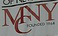
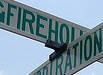
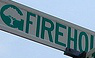
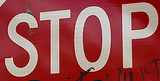
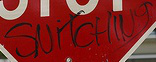
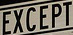
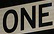
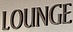
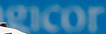
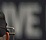
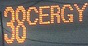
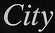
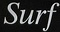
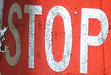
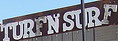
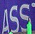
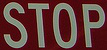
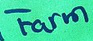
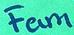
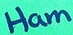
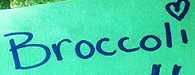
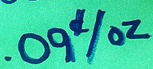
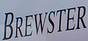
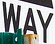
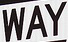
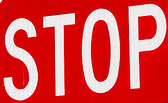
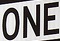
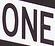
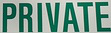
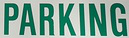
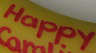
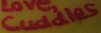
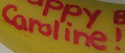
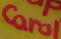
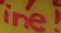
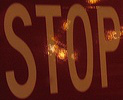
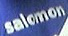
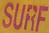
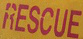

In [62]:
html_all = data.to_html(escape=False)
display(HTML(html_all))

In [64]:
count_conf = [0] * 10001

for conf in data['conf']:
  #print(int(float(conf)*10000))
  conf = int(float(conf)*10000) # conf = (0->10000)
  count_conf[conf] = count_conf[conf] + 1
N = int(100)
cnt = 0
for conf in range(10000,-1,-1):
  cnt += count_conf[conf]
  if(cnt >= N):
    break
print(N)
print(conf)

100
7988


In [72]:
np.array(_dataset.index_list)[non_adapt_mask]

array([  0,   1,   3,   4,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  19,  20,  22,  23,  25,  27,  29,  30,  32,  34,
        36,  39,  40,  41,  42,  44,  45,  46,  47,  49,  50,  51,  52,
        53,  54,  55,  56,  60,  61,  62,  63,  64,  66,  68,  70,  72,
        73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98, 100,
       101, 102, 103, 104, 105, 106, 107, 108, 109, 112, 113, 114, 117,
       118, 119, 125, 126, 127, 128, 129, 130, 131, 132, 133, 135, 136,
       137, 138, 139, 140, 141, 143, 144, 145, 146, 147, 148, 149, 151,
       152, 154, 155, 156, 157, 161, 165, 166, 167, 168, 171, 172, 173,
       174, 175, 176, 177, 178, 180, 182, 183, 185, 187, 188, 189, 190,
       191, 192, 193, 195, 196, 197, 198, 202, 203, 204, 205, 207, 210,
       211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 223, 224,
       225, 226, 227, 228, 229, 230, 232, 234, 235, 236, 237, 23

In [76]:
adapt_mask= np.where(data.conf>0.7988)[0]
non_adapt_mask= np.where(data.conf<=0.7988)[0]

dict(zip(adapt_mask, data.iloc[adapt_mask].label))
label= list(data.iloc[adapt_mask].label)

In [80]:
class subset_dataset(Dataset):
  def __init__(self, dataset, mask_index, label = None):
    self.mask_index= mask_index
    self.index_list=dataset.index_list[mask_index]
    self.dataset = Subset(dataset, self.mask_index)
    self.label = label
    self.nSamples = int(len(self.dataset))
    
  def __len__(self):
    return self.nSamples

  def __getitem__(self, index):
      image = self.dataset[index]
      if self.label is None:
        return image
      label = self.label[index]
      return image, label

In [81]:
adapt_dataset = subset_dataset(_dataset, adapt_mask, label)
non_adapt_dataset= subset_dataset(_dataset, non_adapt_mask)

In [83]:
index=5

print(adapt_dataset[index][1])

['my']


In [85]:
adapt_dataset[index][0]

In [86]:
_adapt_data_loader = torch.utils.data.DataLoader(
  adapt_dataset,
  batch_size=opt.batch_size,
  shuffle=False,
  num_workers=int(opt.workers),
  collate_fn=AlignCollate(opt),
  pin_memory=False,
  drop_last=False,
)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
_adapt_data_loader